# `1) Task-Oriented NLU`

`TASK` -> Smart Home Controller

### `1.1) Imports`

In [1]:
import pandas as pd

In [2]:
nRowsRead = None

fs_df = pd.read_csv('Data/fluent_speech_commands_dataset/data/train_data.csv', delimiter=',', nrows = nRowsRead)
fs_df.dataframeName = 'train_data.csv'
nRow, nCol = fs_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 23132 rows and 7 columns


In [3]:
fs_df.head()

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,0,wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...,2BqVo8kVB2Skwgyb,Change language,change language,none,none
1,1,wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...,2BqVo8kVB2Skwgyb,Resume,activate,music,none
2,2,wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...,2BqVo8kVB2Skwgyb,Turn the lights on,activate,lights,none
3,3,wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-1...,2BqVo8kVB2Skwgyb,Switch on the lights,activate,lights,none
4,4,wavs/speakers/2BqVo8kVB2Skwgyb/1d9f3920-4474-1...,2BqVo8kVB2Skwgyb,Switch off the lights,deactivate,lights,none


**NLU:** `transcription` ---> `intent` + `object` + `location`

In [4]:
fs_df[["object", "location"]].value_counts()

object     location
volume     none        4395
heat       washroom    2565
           none        2105
lights     washroom    1397
           kitchen     1326
music      none        1326
heat       bedroom     1303
           kitchen     1282
lights     bedroom     1109
none       none         994
lights     none         962
lamp       none         792
newspaper  none         551
socks      none         538
shoes      none         536
juice      none         466
Chinese    none         449
English    none         349
Korean     none         345
German     none         342
dtype: int64

### `1.2) Data Exploration`

In [5]:
data = fs_df[["transcription", "action", "object", "location"]]

In [6]:
data.head()

,transcription,action,object,location
0,Change language,change language,none,none
1,Resume,activate,music,none
2,Turn the lights on,activate,lights,none
3,Switch on the lights,activate,lights,none
4,Switch off the lights,deactivate,lights,none


In [7]:
data["action"].value_counts()

increase           5953
decrease           5697
activate           3822
deactivate         3090
change language    2479
bring              2091
Name: action, dtype: int64

In [8]:
data["object"].value_counts()

heat         7255
lights       4794
volume       4395
music        1326
none          994
lamp          792
newspaper     551
socks         538
shoes         536
juice         466
Chinese       449
English       349
Korean        345
German        342
Name: object, dtype: int64

In [9]:
data["location"].value_counts()

none        14150
washroom     3962
kitchen      2608
bedroom      2412
Name: location, dtype: int64

### `1.3) Preprocessing`

#### 1.3.1- text correction

In [10]:
from textblob import TextBlob
import re

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

In [11]:
txt = "turn on the lights!"
txt = str(TextBlob(txt).correct())
txt

'turn on the lights!'

#### 1.3.2- lowecase letters

In [12]:
txt = "For HoNOR"
txt = txt.lower().strip()
txt

'for honor'

#### 1.3.3- remove stopwords

In [13]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

txt = "say hi to the neighbor"
txt = remove_stopwords(txt)
txt

'say hi neighbor'

#### 1.3.4- lemmentization

In [14]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV} 
# Pos tag, used Noun, Verb, Adjective and Adverb

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
#     print(pos_tagged_text)
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

txt = "Ahmad is working on projects"
lemmatize_words(txt)

'Ahmad be work on project'

#### 1.3.5 apply text-cleaning methods


In [15]:
def text_clean(text):
    text = text.lower().strip()
    text = str(TextBlob(text).correct())
    text = lemmatize_words(text)
    text = remove_stopwords(text)
    return text

In [16]:
data["transcription_clean"] = data["transcription"].apply(lambda x: text_clean(x))

C:\Users\modaj\AppData\Local\Temp\ipykernel_88488\3974121563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["transcription_clean"] = data["transcription"].apply(lambda x: text_clean(x))


#### `1.3.6) TF-IDF`

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import preprocessing

In [18]:
tfidf_vectorizer = TfidfVectorizer()

In [19]:
values = tfidf_vectorizer.fit_transform(data["transcription_clean"] )
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# tfidf_df = pd.DataFrame(values.toarray(), columns = tfidf_feature_names)
# tfidf_df

In [20]:
# tfidf_vectorizer.get_feature_names_out()

In [21]:
# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
# tfidf_df = pd.DataFrame(values.toarray(), columns = tfidf_feature_names)
# tfidf_df

#### `1.3.7) encoding categorical features`

In [22]:
le = preprocessing.LabelEncoder()

In [23]:
X = values

le_action = preprocessing.LabelEncoder()
le_object = preprocessing.LabelEncoder()
le_location = preprocessing.LabelEncoder()
y_action, y_object, y_location = le_action.fit_transform(data["action"]),\
                                                  le_object.fit_transform(data["object"]),\
                                                  le_location.fit_transform(data["location"])

# le_action.inverse_transform(y_action)

In [24]:
data["state"] = data["action"] + "-" + data["object"] + "-" + data["location"]
y_state = le.fit_transform(data["state"])

C:\Users\modaj\AppData\Local\Temp\ipykernel_88488\1416426773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["state"] = data["action"] + "-" + data["object"] + "-" + data["location"]


### `1.4) Training`

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### 1.4.1 choosing best model

In [26]:
# Model definitions
MultinomialNB_model = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
LogReg_model = LogisticRegression()
SGDClassifier_model = SGDClassifier(class_weight='balanced', penalty='l1')

models = [MultinomialNB_model, LogReg_model, SGDClassifier_model]
model_names = ['MultinomialNB', 'LogisticRegression', 'SGDClassifier']

def train_and_evaluate(X, y, label_col='y'):
    def train_models(X_tr, X_te, y_tr, y_te):
        for i, model in enumerate(models):
            print(f"Model: {model_names[i]}")
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            print('accuracy %s' % accuracy_score(y_te, y_pred))
            print()
    print("----training on data with labels for column: {}----".format(label_col))
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=110 , stratify=y)
    train_models(X_train, X_test, y_train, y_test)
    print("-" * 100)
    print()
    

In [27]:
# training + simple evaluation
train_and_evaluate(X, y_action, "action")
train_and_evaluate(X, y_object, "object")
train_and_evaluate(X, y_location, "location")
train_and_evaluate(X, y_state, "state")

----training on data with labels for column: action----
Model: MultinomialNB
accuracy 0.7516749513723795

Model: LogisticRegression


C:\Users\modaj\OneDrive\Documents\Personal\Uni\NLP\project\test-venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.7516749513723795

Model: SGDClassifier
accuracy 0.7592392478928031

----------------------------------------------------------------------------------------------------

----training on data with labels for column: object----
Model: MultinomialNB
accuracy 0.988329371082775

Model: LogisticRegression
accuracy 1.0

Model: SGDClassifier
accuracy 1.0

----------------------------------------------------------------------------------------------------

----training on data with labels for column: location----
Model: MultinomialNB
accuracy 0.9394856278366112

Model: LogisticRegression
accuracy 1.0

Model: SGDClassifier
accuracy 1.0

----------------------------------------------------------------------------------------------------

----training on data with labels for column: state----
Model: MultinomialNB
accuracy 0.7516749513723795

Model: LogisticRegression


C:\Users\modaj\OneDrive\Documents\Personal\Uni\NLP\project\test-venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.7609682299546142

Model: SGDClassifier
accuracy 0.7663712988977739

----------------------------------------------------------------------------------------------------



`Evaluation`: Logisitic Regression is the best model in terms of its simplicity and accuracy

In [28]:
# Train Final Model
y_intents = [y_action, y_object, y_location]
y_intents = {"action": y_action, "object": y_object, "location": y_location}
les = {"action": le_action, "object": le_object, "location": le_location}
intent_models = {}
X = values
classes = []

for intent, y_intent in y_intents.items():
    print("column: {}".format(intent))
    LogReg_model = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y_intent, test_size=0.2, random_state=110 , stratify=y_intent)
    LogReg_model.fit(X_train, y_train)
    y_pred = LogReg_model.predict(X_test)
    intent_models[intent] = LogReg_model
    print('accuracy %s' % accuracy_score(y_test, y_pred))
    print()

column: action


C:\Users\modaj\OneDrive\Documents\Personal\Uni\NLP\project\test-venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.7516749513723795

column: object
accuracy 1.0

column: location
accuracy 1.0



### `1.5) Applying Model`

the model trained (logistic regression) is going to be applied in transcripted text for implementation and testing purposes 

In [64]:
# apply intent classification
transcript_eg = "Switch on the lights"

def get_intents(transcript):
    transcript = tfidf_vectorizer.transform([transcript])
    action_pred = les["action"].inverse_transform(intent_models["action"].predict(transcript))[0]
    object_pred = les["object"].inverse_transform(intent_models["object"].predict(transcript))[0]
    location_pred = les["location"].inverse_transform(intent_models["location"].predict(transcript))[0]
    
    state_exists, response = verify_intent(action_pred, object_pred, location_pred)
    if state_exists:
        return {'action': action_pred, 'object': object_pred, 'location': location_pred}
    else:
        return response
        

get_intents(transcript_eg)

{'action': 'activate', 'object': 'lights', 'location': 'none'}

In [41]:
transcript_eg = "open google"
get_intents(transcript_eg)

{'action': 'increase', 'object': 'volume', 'location': 'none'}

In [59]:
def verify_intent(action_inp, object_inp, location_inp):
    allowed_actions = {  'music': ['activate', 'deactivate'],
                         'lights': ['activate', 'deactivate'],
                         'volume': ['increase', 'decrease'],
                         'heat': ['increase', 'decrease'],
                         'lamp': ['activate', 'deactivate'],
                         'newspaper': ['bring'],
                         'juice': ['bring'],
                         'socks': ['bring'],
                         'chinese': ['change language'],
                         'korean': ['change language'],
                         'english': ['change language'],
                         'german': ['change language'],
                         'shoes': ['bring']}
    allowed_rooms = {'music': ["none"],
                     'lights': ["none", "bedroom", "washroom", "kitchen"],
                     'volume': ["none"],
                     'heat': ["none", "bedroom", "washroom", "kitchen"],
                     'lamp': ["none"],
                     'newspaper': ["none"],
                     'juice': ["none"],
                     'socks': ["none"],
                     'chinese': ["none"],
                     'korean': ["none"],
                     'english': ["none"],
                     'german': ["none"],
                     'shoes': ["none"]}
    
    if object_inp in allowed_actions.keys():
        if action_inp in allowed_actions[object_inp]:
            if location_inp in allowed_rooms[object_inp]:
                return True, {"action": action_inp, "object": object_inp, "location": location_inp}
            else:
                return False, "wrong room specification for '{} {}'".format(action_inp, object_inp)  
        else:
            return False, "wrong action for object {}".format(object_inp)
    else:
        return False, "none of the defined objects"

In [62]:
state_exists, response = verify_intent(action_inp="decrease", object_inp="volume", location_inp="bedroom")
print(state_exists)
print(response)

False
wrong room specification for 'decrease volume'


# `2) Non-Task Oriented NLU`

In [1]:
from transformers import pipeline, Conversation

### `2.1) Zero-Shot Classification`

In [32]:
from src.dialog_manager.states import allowed_actions

In [33]:
discourse_labels = ["conversational", "question", "command"]

classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [34]:
# discourse analysis

query_test = "define computers"
zsc_result = classifier(query_test, discourse_labels)
zsc_labels = zsc_result["labels"]  
zsc_scores = zsc_result["scores"]
zsc_result

{'sequence': 'define computers',
 'labels': ['command', 'question', 'conversational'],
 'scores': [0.5320936441421509, 0.361875057220459, 0.10603131353855133]}

`Note` we use 'zsc_labels' instead of 'classifier' list because the order of classes used might change after using classifier

In [52]:
# object and action classification

# query_test = "change language to germany"
# object_labels = ['other', 'music', 'lights', 'volume', 'heat', 'lamp', 'newspaper', 'juice', 'socks',
#             'chinese', 'korean', 'english', 'german', 'shoes']
# action_labels = ['change language', 'activate', 'deactivate', 'increase', 'decrease', 'bring']

# zsc_result = classifier(query_test, object_labels)
# zsc_labels = zsc_result["labels"]  
# zsc_scores = zsc_result["scores"]
# object_chosen = zsc_labels[0]

# zsc_result = classifier(query_test, action_labels)
# zsc_labels = zsc_result["labels"]  
# zsc_scores = zsc_result["scores"]
# action_chosen = zsc_labels[0]

# print("object chosen '{}'".format(object_chosen))
# print("action chosen '{}'".format(action_chosen))

# items_in_house = list(allowed_actions.keys())
# if object_chosen in items_in_house:
#     if action_chosen in allowed_actions[object_chosen]:
#         print("do action in smarthome")
#     else:
#         print("don't do action in smarthome")
# # print("object", zsc_result)
# # print()
# # print("action", zsc_result)

### `2.2) Conversational`

In [7]:
converser = pipeline("conversational",
                      model="facebook/blenderbot-400M-distill")

In [11]:
?Conversation

In [17]:
query_test = "how are you?"
conversation = Conversation(query_test)

In [18]:
response = converser(conversation).generated_responses[-1]
response

' I am doing well, thank you. How are you doing? I hope you are as well.'

In [20]:
conversation.mark_processed()
conversation.append_response(response)
conversation.add_user_input("how are you?")
response = converser(conversation).generated_responses[-1]
response

Conversation input is to long (61), trimming it to (60 - 10)


" I'm doing well. Thank you for asking. What do you like to do for fun?"

### `2.3) Rephrasing`

In [ ]:
from parrot import Parrot
import torch
import warnings
warnings.filterwarnings("ignore")

''' 
uncomment to get reproducable paraphrase generations
def random_state(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random_state(1234)
'''

#Init models (make sure you init ONLY once if you integrate this to your code)
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=False)

In [ ]:
phrases = ["Can you recommed some upscale restaurants in Newyork?",
           "What are the famous places we should not miss in Russia?"
]

for phrase in phrases:
    print("-"*100)
    print("Input_phrase: ", phrase)
    print("-"*100)
    para_phrases = parrot.augment(input_phrase=phrase)
    for para_phrase in para_phrases:
        print(para_phrase)


In [3]:
rephraser = pipeline("text2text-generation",
                      model="prithivida/parrot_paraphraser_on_T5")

In [8]:
query_test = "what do you think of the recent events that transpired in new yourk?"

rephraser(query_test)

[{'generated_text': 'What do you think of the recent events in new yourk?'}]

### `2.4) story telling`

In [8]:
from transformers import pipeline

In [11]:
story_gen = pipeline("text-generation", "pranavpsv/gpt2-genre-story-generator")
print(story_gen("<BOS> <superhero> Batman"))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': '<BOS> <superhero> Batman and Robin, along with Professor Charles Xavier\'s X-Men, raid an underground facility that holds the mutant "Quicksilver". The group includes the superpowered Jean Grey, Iceman, Scarlet Witch, Magik, Sabret'}]


### `2.5) Question Answering`

In [230]:
sentence = "what is the best pizza in the world by Patrick Bateman"
sentence = sentence.lower()

#### `2.5.1) automatic keyword extraction`

In [231]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [232]:
# keyword_tokenizer = AutoTokenizer.from_pretrained("yanekyuk/bert-uncased-keyword-extractor")
keyword_extractor = pipeline("token-classification", model="yanekyuk/bert-uncased-keyword-extractor")

In [233]:
keywords_info = keyword_extractor(sentence)
keywords = list(map(lambda x: (x['entity'], x["word"]), keywords_info))

keywords_processed = []
for key in keywords:
    name = key[1]
    if 'I' in key[0]:
        if "##" in name:
            keywords_processed[-1] = keywords_processed[-1] + "{}".format(name).replace("#", "")
        else:
            keywords_processed[-1] = keywords_processed[-1] + " {}".format(name)
    else:
        keywords_processed.append(name)
print(keywords_processed)

['pizza', 'patrick bateman']


#### `2.5.2) POS tags`

In [234]:
import nltk
from nltk import word_tokenize

nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\modaj\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [235]:
tokenized_word = word_tokenize(sentence)
pos_tags = nltk.pos_tag(tokenized_word, tagset='universal')

adjectives = [i[0] for i in pos_tags if i[1] == "ADJ"]
nouns = [i[0] for i in pos_tags if i[1] == "NOUN"]

In [236]:
nouns, adjectives

(['pizza', 'world', 'bateman'], ['best', 'patrick'])

In [237]:
new_keywords_processed = []

for adj_i in adjectives:
    matched = False
    for keyword_i in keywords_processed: 
        print("if {} in '{}''".format(adj_i, keyword_i))
        if adj_i in keyword_i:
            matched = True
            break
            
    if not matched:
        new_keywords_processed.append(adj_i)
print(new_keywords_processed)

for noun_i in nouns:
    matched = False
    for keyword_i in keywords_processed: 
        print("if {} in '{}''".format(noun_i, keyword_i))
        if noun_i in keyword_i:
            matched = True
            break
            
    if not matched:
        new_keywords_processed.append(noun_i)
print(new_keywords_processed)

if best in 'pizza''
if best in 'patrick bateman''
if patrick in 'pizza''
if patrick in 'patrick bateman''
['best']
if pizza in 'pizza''
if world in 'pizza''
if world in 'patrick bateman''
if bateman in 'pizza''
if bateman in 'patrick bateman''
['best', 'world']


In [238]:
keywords_processed.extend(new_keywords_processed)

In [240]:
keywords_processed

['pizza', 'patrick bateman', 'best', 'world']

#### `2.5.3) NER tags` (Failed)

In [224]:
import nltk
from nltk import word_tokenize
from nltk import ne_chunk

nltk.download('universal_tagset')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\modaj\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\modaj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\modaj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

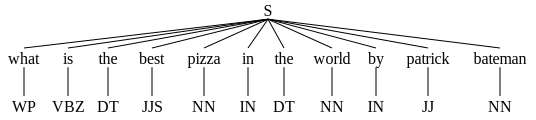

In [242]:
text_token = word_tokenize(sentence)
tags = nltk.pos_tag(text_token)
chunk = ne_chunk(tags)
chunk
# chunk.pos()

`note`: we can't use NER, due to the nature of speech recogntion not being case-sensitive in output

#### `2.5.4) QA model`

In [261]:
import wikipedia

In [287]:
query = "what is google"

In [308]:
search_reult = wikipedia.search(query)[0]
search_reult

'List of The Good Fight episodes'

In [289]:
results = wikipedia.summary("what is " + "google", sentences=5)

In [306]:
query = "what is fighting good"

In [307]:
try:
    results = wikipedia.summary(query, sentences=5)
    print(results)
except:
    print('fiale')

The Good Fight is an American legal drama produced for CBS's streaming service CBS All Access (later Paramount+). It is the platform's first original scripted series. The series, created by Robert King, Michelle King, and Phil Alden Robinson, is a spin-off and sequel to The Good Wife, which was created by the Kings. The first season premiered on February 19, 2017, with the first episode airing on CBS and the following episodes on CBS All Access.On July 20, 2021, Paramount+ renewed the series for a sixth season. On May 27, 2022, it was announced that the sixth season will be the series' last;  it premiered on September 8, 2022.


---

# `3) using source code (src)`

--> **implementing with scripts written in src folder**

### `3.1) src implementation` - training

In [24]:
import pandas as pd
from src.NLU.preprocess import prepare_data, get_tfidf, encode_label, split
from src.NLU.intention import IntentRecognizer
import pickle

In [9]:
fs_df = pd.read_csv('Data/fluent_speech_commands_dataset/data/train_data.csv', delimiter=',')

In [10]:
fs_df_clean = prepare_data(fs_df)

C:\Users\modaj\OneDrive\Documents\Personal\Uni\NLP\project\src\NLU\preprocess.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["transcription_clean"] = data["transcription"].apply(lambda x: text_clean(x))


In [11]:
X, tfidf_vectorizer = get_tfidf(fs_df_clean["transcription_clean"])

In [12]:
les = {}
ys = {}
ys["action"], les["action"] = encode_label(fs_df_clean["action"])
ys["object"], les["object"] = encode_label(fs_df_clean["object"])
ys["location"], les["location"] = encode_label(fs_df_clean["location"])

print(les)
print(ys)

{'action': LabelEncoder(), 'object': LabelEncoder(), 'location': LabelEncoder()}
{'action': array([2, 0, 0, ..., 2, 2, 3]), 'object': array([10,  8,  7, ...,  3,  1,  7]), 'location': array([2, 2, 2, ..., 2, 2, 3])}


In [13]:
ir = IntentRecognizer()

In [14]:
for intent, y_intent in ys.items():
    print("intent: {}".format(intent))
    X_train, X_test, ys_train, ys_test = split(X, ys[intent], test_size=0.2, stratify=True)
    
    ir.learn_intents(X_train, ys_train, intent)
    ir.evaluate(X_test, ys_test, intent)
    print("-" * 50)
    

intent: action
accuracy 1.0
--------------------------------------------------
intent: object
accuracy 1.0
--------------------------------------------------
intent: location
accuracy 1.0
--------------------------------------------------


In [15]:
ir.intent_models

{'action': LogisticRegression(),
 'object': LogisticRegression(),
 'location': LogisticRegression()}

In [16]:
transcript_eg = "activate lights in kitchen"
ir.get_intents(transcript_eg, les, tfidf_vectorizer)

{'action': 'activate', 'object': 'lights', 'location': 'kitchen'}

In [18]:
# save work
with open('Saved/intention_models.pickle', 'wb') as handle:
    pickle.dump(ir.intent_models, handle, protocol=4)  
with open('Saved/tfidfV.pickle', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=4)  
with open('Saved/les.pickle', 'wb') as handle:
    pickle.dump(les, handle, protocol=4)  

### `3.2) src implementation` - usage

In [22]:
from src.dialog_manager.manage import verify_intent

In [25]:
with open('Saved/intention_models.pickle', 'rb') as handle:
    intention_models_b = pickle.load(handle)
with open('Saved/tfidfV.pickle', 'rb') as handle:
    tfidfv_b = pickle.load(handle)
with open('Saved/les.pickle', 'rb') as handle:
    les_b = pickle.load(handle)

In [26]:
ir_b = IntentRecognizer()

In [27]:
ir_b.intent_models = intention_models_b

In [33]:
transcript_eg = "activate lights in washroom in home"

if "in home" in transcript_eg:
    intents = ir_b.get_intents(transcript_eg, les_b, tfidfv_b)
    ver_state, ver_intent = verify_intent(intents["action"], intents["object"], intents["location"])
    if not ver_state:
        pass
    else:
        print(ver_intent)


{'action': 'activate', 'object': 'lights', 'location': 'washroom'}


In [29]:
ver_state, ver_intent = verify_intent(intents["action"], intents["object"], intents["location"])
print("intent verfied: {}".format(ver_state))
print()
print("intents: {}".format(ver_intent))

intent verfied: True

intents: {'action': 'activate', 'object': 'lights', 'location': 'washroom'}


In [30]:
import en

ModuleNotFoundError: No module named 'en'

---

## Further Work

- https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85
- https://igorizraylevych.medium.com/how-do-task-oriented-dialogue-systems-work-and-what-benefits-they-bring-for-business-20691bf2e0ae
- https://medium.com/analytics-vidhya/creating-your-own-intent-classifier-b86e000a4926
- https://medium.com/analytics-vidhya/a-guide-to-your-own-a-i-voice-assistant-using-python-17f79c94704

- https://www.kaggle.com/datasets/elvinagammed/chatbots-intent-recognition-dataset
- https://www.kaggle.com/datasets/lorencpetr/chatbot-intent-classification